In [252]:
import pandas as pd
import datetime
import numpy as np

In [253]:
wines_ = pd.read_excel("data/Subset1.xls", 1)
print(min(wines_['DOY']))

213.0


On ne peut donc au maximum prendre comme data que les 213 jours précédent la récolte, une information supplémentaire n'est probablement pas importante car on va surtout analyser l'effet de la météo d'une année sur le vin

In [254]:
wines_.dropna(subset = ['Harvest date'], inplace=True)
wines_.reset_index(drop=True, inplace=True)

In [255]:
weather = pd.read_excel("data/Subset3.xls", [1,2,3,4,5])
weather[1]

,Year,Month,day,Tave,Tmax,Tmin,DOY,Unnamed: 7,Year.1,GST,WI,HI
0,1911,1,1,8.35,16.7,0.0,1,NaN,1911.0,15.073364,1099.050000,967.254052
1,1911,1,2,8.85,19.4,-1.7,2,NaN,1912.0,15.752336,1246.550000,1146.450272
2,1911,1,3,6.65,16.1,-2.8,3,NaN,1913.0,16.722430,1446.300000,1276.779404
3,1911,1,4,8.30,18.3,-1.7,4,NaN,1914.0,15.678579,1217.966001,1103.276910
4,1911,1,5,7.80,18.9,-3.3,5,NaN,1915.0,15.950196,1277.291993,1133.617078
...,...,...,...,...,...,...,...,...,...,...,...,...
36885,2011,12,27,6.95,15.6,-1.7,361,NaN,NaN,NaN,NaN,NaN
36886,2011,12,28,11.65,19.4,3.9,362,NaN,NaN,NaN,NaN,NaN
36887,2011,12,29,11.15,16.7,5.6,363,NaN,NaN,NaN,NaN,NaN
36888,2011,12,30,12.20,15.0,9.4,364,NaN,NaN,NaN,NaN,NaN


In [256]:
i = list(range(1,201))
i = list(map(str, i))
iavg = ['avg' + item for item in i]
imin = ['min' + item for item in i]
imax = ['max' + item for item in i]
temp_avg = pd.DataFrame(columns = iavg)
temp_min = pd.DataFrame(columns = imin)
temp_max = pd.DataFrame(columns = imax)

In [257]:
wines = wines_.copy()

In [258]:
for i in range(len(wines)):
    new_row = []
    r = wines["Reg"][i]
    d = wines['Harvest date'][i]
    h = int(wines['DOY'][i])
    new_row = list(weather[r].loc[(weather[r]['Year'] == d.year) & (weather[r]['DOY'].isin(range(h-200,h)))]['Tave'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_avg.loc[len(temp_avg)] = new_row

In [259]:
for i in range(len(wines)):
    new_row = []
    r = wines["Reg"][i]
    d = wines['Harvest date'][i]
    h = int(wines['DOY'][i])
    new_row = list(weather[r].loc[(weather[r]['Year'] == d.year) & (weather[r]['DOY'].isin(range(h-200,h)))]['Tmin'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_min.loc[len(temp_min)] = new_row

In [260]:
for i in range(len(wines)):
    new_row = []
    r = wines["Reg"][i]
    d = wines['Harvest date'][i]
    h = int(wines['DOY'][i])
    new_row = list(weather[r].loc[(weather[r]['Year'] == d.year) & (weather[r]['DOY'].isin(range(h-200,h)))]['Tmax'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_max.loc[len(temp_max)] = new_row


In [261]:
print(temp_avg.isnull().sum(axis = 0))
print(temp_min.isnull().sum(axis = 0))
print(temp_max.isnull().sum(axis = 0))

avg1      102
avg2      102
avg3      102
avg4      102
avg5      102
         ... 
avg196    102
avg197    102
avg198    102
avg199    102
avg200    102
Length: 200, dtype: int64
min1      102
min2      102
min3      102
min4      102
min5      102
         ... 
min196    102
min197    102
min198    102
min199    102
min200    102
Length: 200, dtype: int64
max1      102
max2      102
max3      102
max4      102
max5      102
         ... 
max196    102
max197    102
max198    102
max199    102
max200    102
Length: 200, dtype: int64


we have the same missing values for Tmin, Tmax and Taverage

In [262]:
temperatures = temp_avg.copy()

In [263]:
mapping = {'White': -1, 'Red': 1}

# Apply the mapping to the 'category' column using the map() function
wines['Color'] = wines['Color'].map(mapping)

wines

,Table.No.,Cultivar,Color,Recommend,RecReg,Reg,Harvest date,DOY,Must.Brix,Must.Tacid,Must.pH,Wine.Alcohol,Wine.Facid,Wine.Extract,Wine.Tannin,Wine.Tasting
0,9,Chardony,-1,Particularly recommended,1.0,3,1936-09-08,251.0,27.2,0.54,3.88,15.6,0.42,4.0,0.03,"Very distinct; good, but alcoholic"
1,9,Chardony,-1,Particularly recommended,1.0,4,1936-08-31,243.0,23.5,0.67,3.79,13.0,0.39,NaN,NaN,Distinct; lacks acid; standard quality
2,9,Chardony,-1,Particularly recommended,1.0,1,1937-10-01,273.0,22.1,0.72,3.38,12.0,0.52,2.0,0.03,Light body; fruity; distinct; good quality
3,9,Chardony,-1,Particularly recommended,1.0,3,1937-09-11,253.0,24.6,0.63,3.69,12.8,0.49,2.1,0.03,Flat; tends to oxidize; but distinct
4,9,Chardony,-1,Particularly recommended,1.0,1,1938-09-14,256.0,19.8,0.78,3.19,10.5,0.68,2.8,0.07,"Tart, but palatable; distinct; picked too early"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,25,Red Malaga (Molinera),1,Table grape,NaN,4,1937-10-25,297.0,21.8,0.47,3.74,12.0,0.28,2.3,0.04,Very flat; some spoilage; very ordiry sherry
1469,25,Red Malaga (Molinera),1,Table grape,NaN,4,1940-10-07,280.0,22.7,0.36,3.90,12.4,0.40,2.8,0.04,Flat; pink; very common; lacks everything
1470,25,Ribier,1,Table grape,NaN,4,1935-11-01,304.0,20.2,0.55,NaN,10.8,0.34,2.5,0.08,"Flat; poor; sherry; soft, but no character"
1471,25,Ribier,1,Table grape,NaN,4,1937-10-13,285.0,17.6,0.50,3.58,9.5,0.35,2.1,0.06,Flat; ordiry; tends to spoil


In [264]:
dataset = pd.concat([wines,temp_avg], axis = 1)

In [265]:
print(dataset.isna().sum()) #il faudrait trouver et enlever les 102 wines ou on a pas la temperature selon mon avis 

Table.No.       0
Cultivar        0
Color           0
Recommend       0
RecReg       1025
             ... 
avg196        102
avg197        102
avg198        102
avg199        102
avg200        102
Length: 216, dtype: int64


# Mise en place d'une analyse avec tout d'abord la color du wine comme attribute et le ph à prédire

In [320]:
tested = 'Wine.Alcohol'
to_drop = ['Table.No.', 'Cultivar', 'Recommend', 'RecReg', 'Reg', 'Must.pH','Wine.Alcohol',
       'Harvest date', 'DOY', 'Must.Brix', 'Must.Tacid', 'Wine.Facid', 'Wine.Extract', 'Wine.Tannin',
       'Wine.Tasting']
to_drop.remove(tested)

In [321]:
copie = dataset.copy()
#enlever les colonnes qu'on ne compte pas utiliser
copie = copie.drop(columns = to_drop)
#verifier qu'on a nos colonnes désirées
copie.columns 

Index(['Color', 'Wine.Alcohol', 'avg1', 'avg2', 'avg3', 'avg4', 'avg5', 'avg6',
       'avg7', 'avg8',
       ...
       'avg191', 'avg192', 'avg193', 'avg194', 'avg195', 'avg196', 'avg197',
       'avg198', 'avg199', 'avg200'],
      dtype='object', length=202)

In [322]:
columns = list(temperatures.columns)
columns.append('Color')
columns.append(tested)
#delete row with value = Nan
#voir si pour les y on peut pas remplacer par une valeur :
# d'autres possibilités (ffill et bfill qui propagent les valeurs observées aux voisines Nan)
# imputation par la moyenne (possible aussi avec la mediane)
# exemple :           movies_df['budget'].fillna(movies_df['budget'].mean(), inplace=True)
copie.dropna(subset = columns, inplace=True)
copie.reset_index(drop=True, inplace=True)

In [324]:
# classe à prédire
y = copie[[tested]]

colonnes = list(temperatures.columns)
colonnes.append('Color')

X = copie[colonnes]

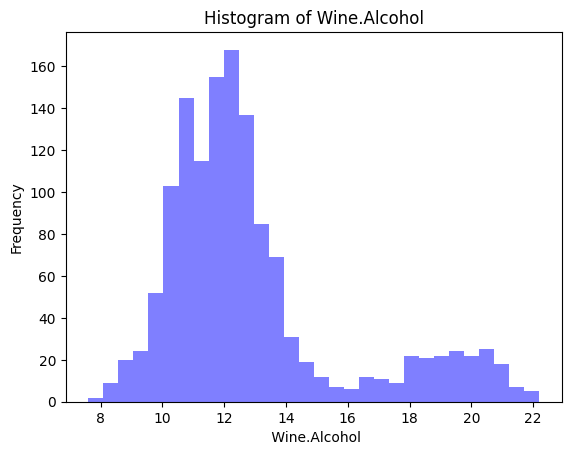

In [415]:
import matplotlib.pyplot as plt
import pandas as pd

values_to_plot = copie[tested]

# Create the histogram
plt.hist(values_to_plot, bins=30, color='blue', alpha=0.5)

# Set the title and axis labels
plt.title(f'Histogram of {tested}')
plt.xlabel(f' {tested}')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [325]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [326]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), iavg)  
    ],
    remainder='passthrough' 
)

exp_models = {}


In [394]:
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from scipy.stats import loguniform
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


scorers = {
    'mse': make_scorer(mean_squared_error, squared = False, greater_is_better=False),
    'r2': make_scorer(r2_score)
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)

#linear regression avec lasso et ridge 
alphas = loguniform(1e-3, 2e1)

param_dist = {'reg__alpha': alphas}

pLasso = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', Lasso())
])

pRidge = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', Ridge())
])

rand_lass = RandomizedSearchCV(pLasso, param_distributions=param_dist, scoring=scorers, refit='mse',verbose=1, n_iter=40, cv=cv, random_state=7)
rand_rid = RandomizedSearchCV(pRidge, param_distributions=param_dist, scoring=scorers, refit='mse',verbose=1, n_iter=40, cv=cv, random_state=7)


rand_lass.fit(X_train, y_train.values.ravel())
rand_rid.fit(X_train, y_train.values.ravel())

exp_models["rand_lass"]=rand_lass
exp_models["rand_rid"]=rand_rid


print("Best hyperparameters: ", rand_lass.best_params_)
print("Cross-validation score: ", rand_lass.best_score_)

print("Best hyperparameters: ", rand_rid.best_params_)
print("Cross-validation score: ", rand_rid.best_score_)



Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best hyperparameters:  {'reg__alpha': 0.08802351793763162}
Cross-validation score:  -2.704135106644166
Best hyperparameters:  {'reg__alpha': 16.082820934058393}
Cross-validation score:  -2.7834424855275985


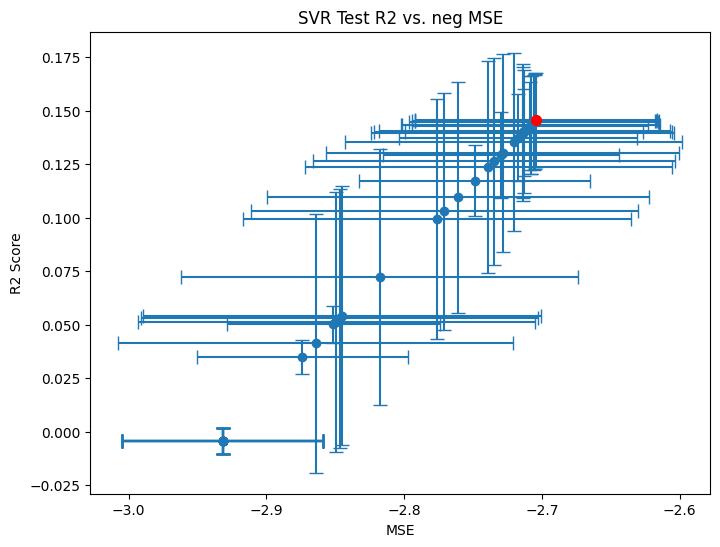

In [389]:
import matplotlib.pyplot as plt


mean_test_scores = rand_lass.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_lass.cv_results_['mean_test_r2']
std_test_score = rand_lass.cv_results_['std_test_mse']
std_test_r2_scores = rand_lass.cv_results_['std_test_r2']
best_i = rand_lass.best_index_

plt.figure(figsize=(8, 6))
plt.errorbar(mean_test_scores, mean_test_r2_scores, xerr = std_test_score ,yerr=std_test_r2_scores, fmt='o', capsize=5)
plt.scatter(mean_test_scores[best_i], mean_test_r2_scores[best_i], color='red', s=50, zorder=10)
plt.xlabel('MSE')
plt.ylabel('R2 Score')
plt.title('SVR Test R2 vs. neg MSE')
plt.show()

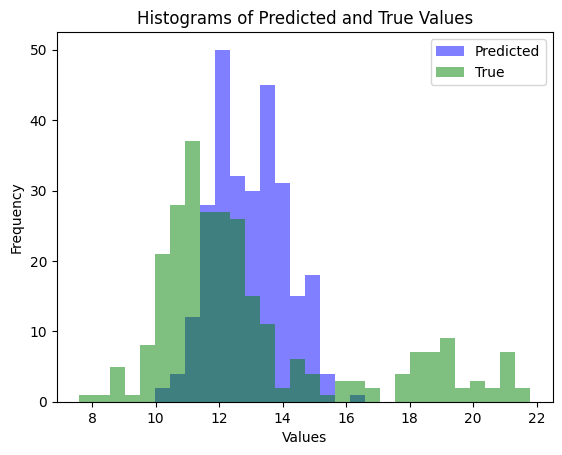

In [437]:
predicted_values = rand_lass.predict(X_test)
true_values = y_test
min_value = min(min(predicted_values), min(true_values[tested]))
max_value = max(max(predicted_values), max(true_values[tested]))

plt.hist(predicted_values, bins=30, range=(min_value, max_value), color='blue', alpha=0.5, label='Predicted')
plt.hist(true_values, bins=30, range=(min_value, max_value), color='green', alpha=0.5, label='True')

plt.title('Histograms of Predicted and True Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.legend(loc='upper right')

plt.show()

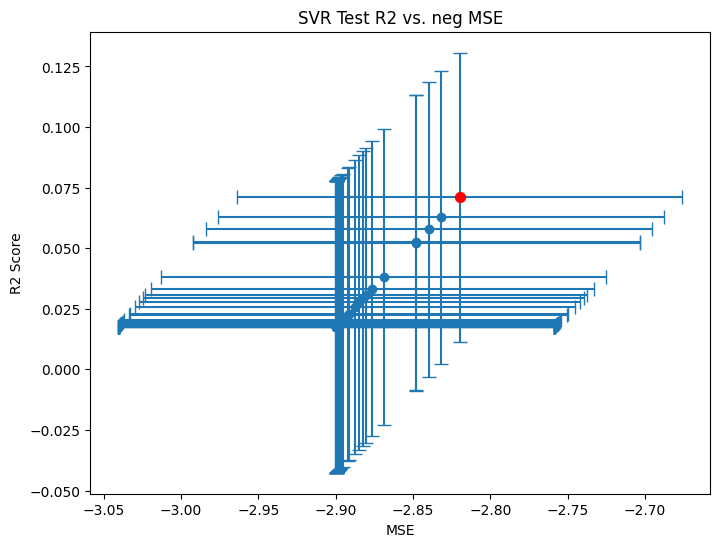

In [390]:
import matplotlib.pyplot as plt


mean_test_scores = rand_rid.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_rid.cv_results_['mean_test_r2']
std_test_score = rand_rid.cv_results_['std_test_mse']
std_test_r2_scores = rand_rid.cv_results_['std_test_r2']
best_i = rand_rid.best_index_

plt.figure(figsize=(8, 6))
plt.errorbar(mean_test_scores, mean_test_r2_scores, xerr = std_test_score ,yerr=std_test_r2_scores, fmt='o', capsize=5)
plt.scatter(mean_test_scores[best_i], mean_test_r2_scores[best_i], color='red', s=50, zorder=10)
plt.xlabel('MSE')
plt.ylabel('R2 Score')
plt.title('SVR Test R2 vs. neg MSE')
plt.show()

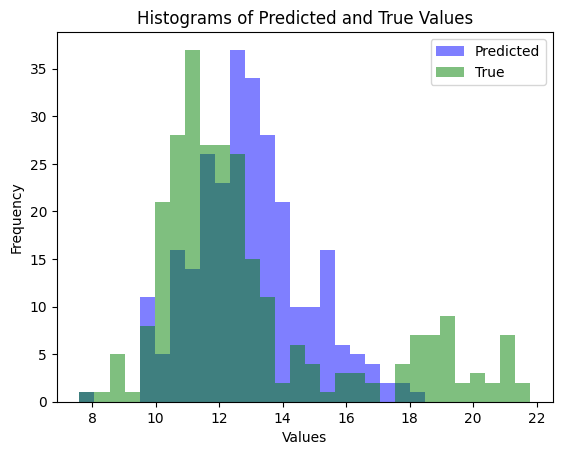

In [438]:
predicted_values = rand_rid.predict(X_test)
true_values = y_test
min_value = min(min(predicted_values), min(true_values[tested]))
max_value = max(max(predicted_values), max(true_values[tested]))

plt.hist(predicted_values, bins=30, range=(min_value, max_value), color='blue', alpha=0.5, label='Predicted')
plt.hist(true_values, bins=30, range=(min_value, max_value), color='green', alpha=0.5, label='True')



plt.title('Histograms of Predicted and True Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.legend(loc='upper right')

plt.show()

In [407]:
from sklearn.kernel_ridge import KernelRidge

param_dist_kr = {'reg__alpha': loguniform(1e-2, 1e1),
            'reg__gamma': loguniform(1e-3, 1e1),
            'reg__kernel':['linear', 'poly', 'rbf', 'sigmoid', 'laplacian']}

pKerR = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', KernelRidge())
])


rand_KerR = RandomizedSearchCV(pKerR, param_distributions=param_dist_kr, scoring=scorers, refit='mse',verbose=1, n_iter=50, cv=cv, random_state=7)

rand_KerR.fit(X_train, y_train.values.ravel())
exp_models["rand_lin"]=rand_KerR
print("Best hyperparameters: ", rand_KerR.best_params_)
print("Cross-validation score: ", rand_KerR.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/augustin/Documents/M1/projectML/project/projet_wine/.conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/augustin/Documents/M1/projectML/project/projet_wine/.conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/augustin/Documents/M1/projectML/project/projet_wine/.conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/augustin/Documents/M1/projectML/project/projet_wine/.conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/augustin/Documents/M1/projectML/projec

Best hyperparameters:  {'reg__alpha': 0.5692452403551341, 'reg__gamma': 0.004566579044119521, 'reg__kernel': 'laplacian'}
Cross-validation score:  -2.680156386380811


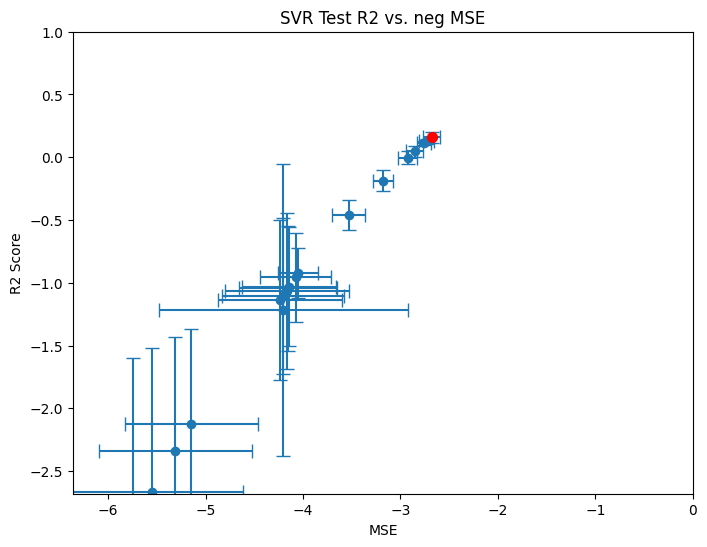

In [408]:
import matplotlib.pyplot as plt


mean_test_scores = rand_KerR.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_KerR.cv_results_['mean_test_r2']
std_test_score = rand_KerR.cv_results_['std_test_mse']
std_test_r2_scores = rand_KerR.cv_results_['std_test_r2']
best_i = rand_KerR.best_index_

plt.figure(figsize=(8, 6))
plt.errorbar(mean_test_scores, mean_test_r2_scores, xerr = std_test_score ,yerr=std_test_r2_scores, fmt='o', capsize=5)
plt.scatter(mean_test_scores[best_i], mean_test_r2_scores[best_i], color='red', s=50, zorder=10)
plt.xlabel('MSE')
plt.xlim(2*rand_KerR.best_score_-1,0)
plt.ylim(rand_KerR.best_score_,1)
plt.ylabel('R2 Score')
plt.title('SVR Test R2 vs. neg MSE')
plt.show()

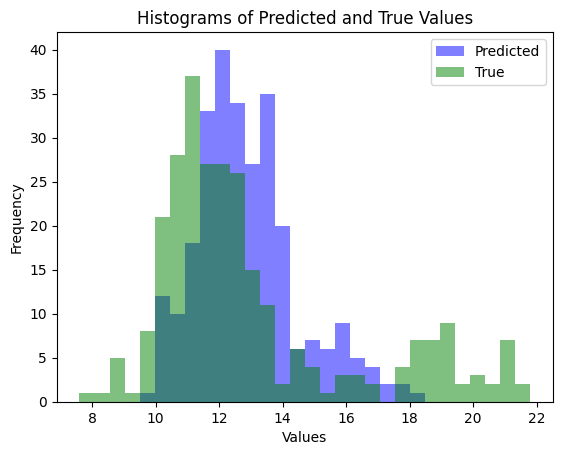

In [439]:
predicted_values = rand_KerR.predict(X_test)
true_values = y_test
min_value = min(min(predicted_values), min(true_values[tested]))
max_value = max(max(predicted_values), max(true_values[tested]))

plt.hist(predicted_values, bins=30, range=(min_value, max_value), color='blue', alpha=0.5, label='Predicted')
plt.hist(true_values, bins=30, range=(min_value, max_value), color='green', alpha=0.5, label='True')



plt.title('Histograms of Predicted and True Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.legend(loc='upper right')

plt.show()

In [356]:
from sklearn.svm import SVR


In [357]:
c_values = loguniform(1e-3, 1e0)
epsilon_values = loguniform(1e-3, 1)


In [358]:
pSVRlin = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(kernel='linear'))
])

param_dist_lin = {'svr__C': c_values, 
              'svr__epsilon': epsilon_values}

rand_lin = RandomizedSearchCV(pSVRlin, param_distributions=param_dist_lin, scoring=scorers, refit='mse',verbose=1, n_iter=20, cv=cv, random_state=7)

rand_lin.fit(X_train, y_train.values.ravel())
exp_models["rand_lin"]=rand_lin
print("Best hyperparameters: ", rand_lin.best_params_)
print("Cross-validation score: ", rand_lin.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'svr__C': 0.020664632886986636, 'svr__epsilon': 0.14804560990495677}
Cross-validation score:  -2.7523139998227326


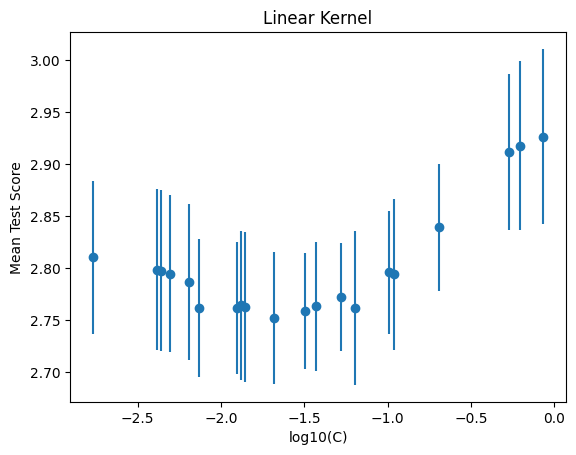

In [359]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the results from the RandomizedSearchCV object
results = rand_lin.cv_results_
mean_test_score = -results['mean_test_mse']
std_test_score = results['std_test_mse']
C_values = np.array([np.log10(float(c)) for c in results['param_svr__C']])
epsilon_values = np.array([np.log10(float(e)) for e in results['param_svr__epsilon']])

# Plot the mean test scores for each value of C
plt.errorbar(C_values, mean_test_score, yerr=std_test_score, fmt='o')
plt.xlabel('log10(C)')
plt.ylabel('Mean Test Score')
plt.title('Linear Kernel')
plt.show()

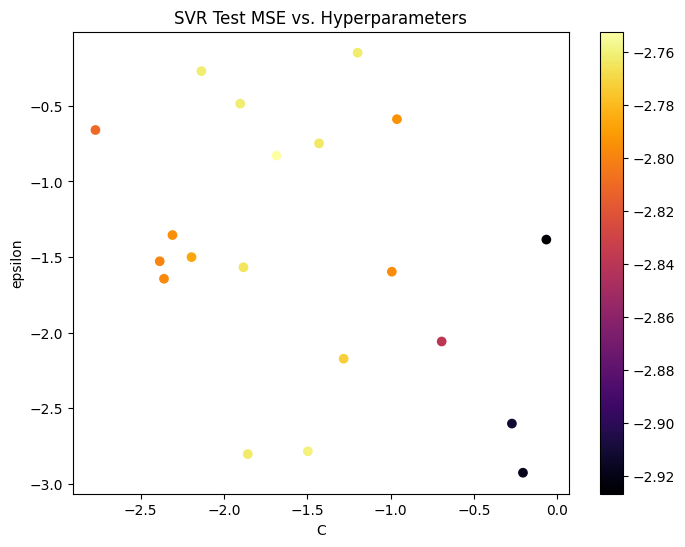

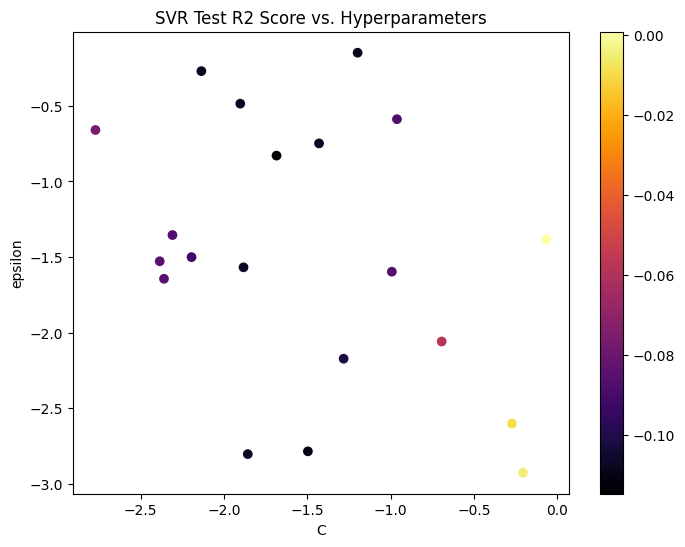

In [360]:
import matplotlib.pyplot as plt

# Extract the hyperparameters and test scores from the RandomizedSearchCV results
C_values = rand_lin.cv_results_['param_svr__C'].data
epsilon_values = rand_lin.cv_results_['param_svr__epsilon'].data
mean_test_scores = rand_lin.cv_results_['mean_test_mse']
mean_test_r2_scores = -rand_lin.cv_results_['mean_test_r2']
mse_,r2_=np.array([np.log10(float(c)) for c in C_values]), np.array([np.log10(float(e)) for e in epsilon_values])

# Plot the mean test scores as a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(np.array([np.log10(float(c)) for c in C_values]), np.array([np.log10(float(e)) for e in epsilon_values]), c=mean_test_scores, cmap='inferno')
plt.colorbar()
plt.xlabel('C')
plt.ylabel('epsilon')
plt.title('SVR Test MSE vs. Hyperparameters')
plt.show()

# Plot the mean test r2 scores as a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(np.array([np.log10(float(c)) for c in C_values]), np.array([np.log10(float(e)) for e in epsilon_values]), c=mean_test_r2_scores, cmap='inferno')
plt.colorbar()
plt.xlabel('C')
plt.ylabel('epsilon')
plt.title('SVR Test R2 Score vs. Hyperparameters')
plt.show()

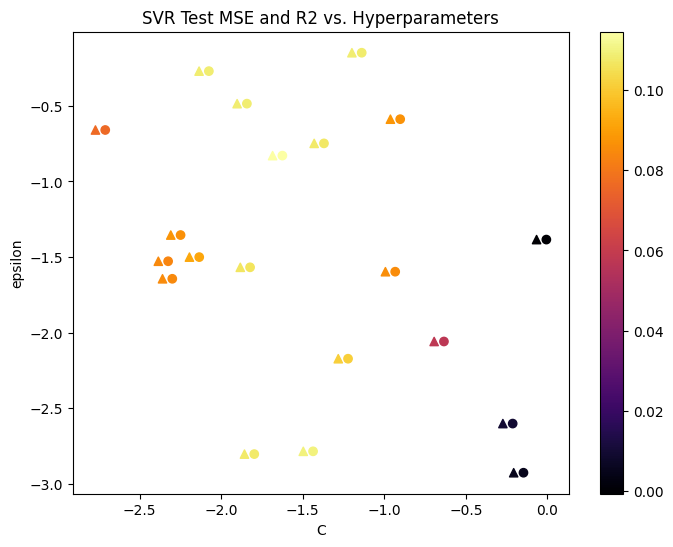

In [361]:
import matplotlib.pyplot as plt

# Extract the hyperparameters and test scores from the RandomizedSearchCV results
C_values = rand_lin.cv_results_['param_svr__C'].data
epsilon_values = rand_lin.cv_results_['param_svr__epsilon'].data
mean_test_scores = rand_lin.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_lin.cv_results_['mean_test_r2']

# Plot the mean test scores as a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(np.array([np.log10(float(c))+0.06 for c in C_values]), np.array([np.log10(float(e)) for e in epsilon_values]), c=mean_test_scores, cmap='inferno', marker='o')
plt.scatter(np.array([np.log10(float(c)) for c in C_values]), np.array([np.log10(float(e)) for e in epsilon_values]), c=mean_test_r2_scores, cmap='inferno', marker='^')
plt.colorbar()
plt.xlabel('C')
plt.ylabel('epsilon')
plt.title('SVR Test MSE and R2 vs. Hyperparameters')
plt.show()

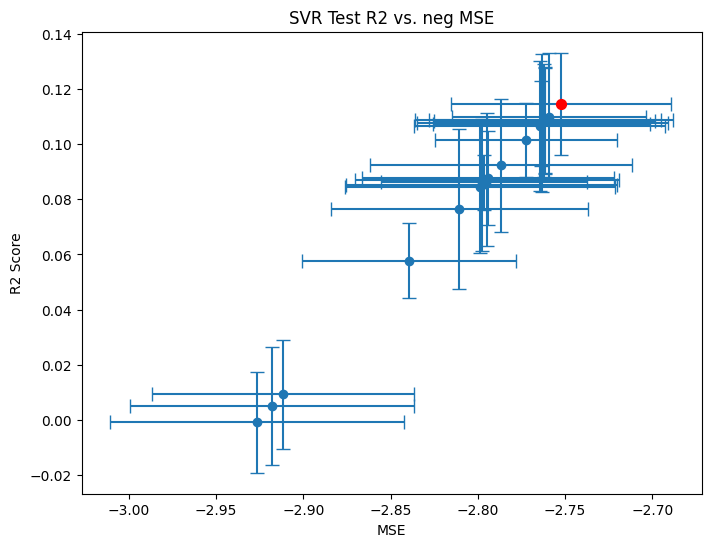

In [362]:
import matplotlib.pyplot as plt

# Extract the hyperparameters and test scores from the RandomizedSearchCV results
C_values = rand_lin.cv_results_['param_svr__C'].data
epsilon_values = rand_lin.cv_results_['param_svr__epsilon'].data
mean_test_scores = rand_lin.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_lin.cv_results_['mean_test_r2']
std_test_score = rand_lin.cv_results_['std_test_mse']
std_test_r2_scores = rand_lin.cv_results_['std_test_r2']
best_i = rand_lin.best_index_

plt.figure(figsize=(8, 6))
plt.errorbar(mean_test_scores, mean_test_r2_scores, xerr = std_test_score ,yerr=std_test_r2_scores, fmt='o', capsize=5)
plt.scatter(mean_test_scores[best_i], mean_test_r2_scores[best_i], color='red', s=50, zorder=10)
plt.xlabel('MSE')
plt.ylabel('R2 Score')
plt.title('SVR Test R2 vs. neg MSE')
plt.show()

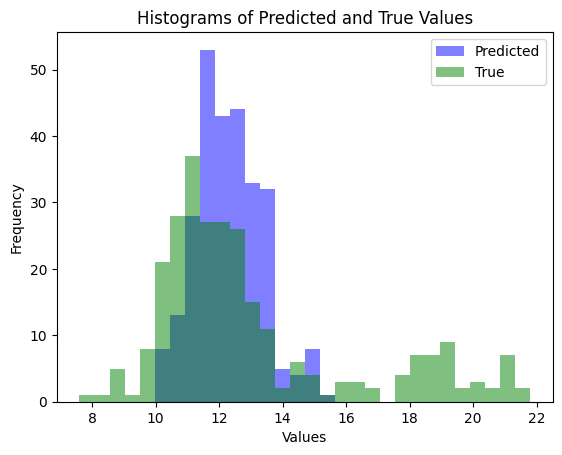

In [440]:
predicted_values = rand_lin.predict(X_test)
true_values = y_test
min_value = min(min(predicted_values), min(true_values[tested]))
max_value = max(max(predicted_values), max(true_values[tested]))

plt.hist(predicted_values, bins=30, range=(min_value, max_value), color='blue', alpha=0.5, label='Predicted')
plt.hist(true_values, bins=30, range=(min_value, max_value), color='green', alpha=0.5, label='True')



plt.title('Histograms of Predicted and True Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.legend(loc='upper right')

plt.show()

In [363]:
pSVRrbf = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(kernel='rbf'))
])


param_dist_rbf = {'svr__C': c_values,
                  'svr__epsilon': epsilon_values,
                  'svr__gamma': ['scale', 'auto']}

rand_rbf = RandomizedSearchCV(pSVRrbf, param_distributions=param_dist_rbf, 
                              scoring=scorers, refit='mse', verbose=1, cv=cv,
                              n_iter=20, random_state=7)

rand_rbf.fit(X_train, y_train.values.ravel())
exp_models["rand_rbf"]=rand_rbf
print("Best hyperparameters: ", rand_rbf.best_params_)
print("Cross-validation score: ", rand_rbf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'svr__C': 0.7140769780766246, 'svr__epsilon': 0.7085793657037958, 'svr__gamma': 'auto'}
Cross-validation score:  -2.7317679250898728


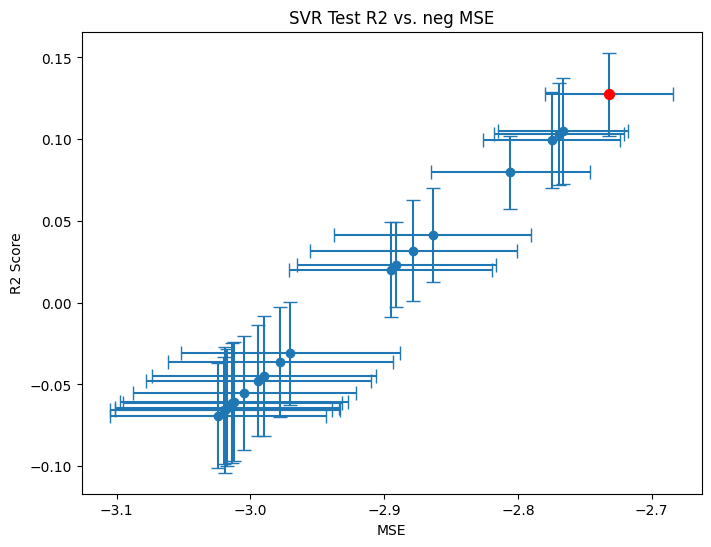

In [364]:
mean_test_scores = rand_rbf.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_rbf.cv_results_['mean_test_r2']
std_test_score = rand_rbf.cv_results_['std_test_mse']
std_test_r2_scores = rand_rbf.cv_results_['std_test_r2']
best_i = rand_rbf.best_index_

plt.figure(figsize=(8, 6))
plt.errorbar(mean_test_scores, mean_test_r2_scores, xerr = std_test_score ,yerr=std_test_r2_scores, fmt='o', capsize=5)
plt.scatter(mean_test_scores[best_i], mean_test_r2_scores[best_i], color='red', s=50, zorder=10)
plt.xlabel('MSE')
plt.ylabel('R2 Score')
plt.title('SVR Test R2 vs. neg MSE')
plt.show()

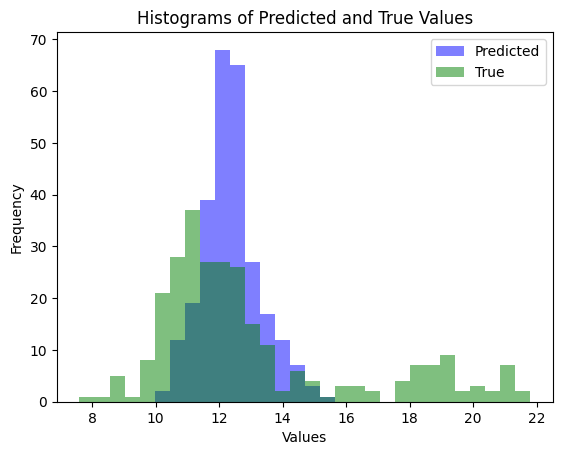

In [441]:
predicted_values = rand_rbf.predict(X_test)
true_values = y_test
min_value = min(min(predicted_values), min(true_values[tested]))
max_value = max(max(predicted_values), max(true_values[tested]))

plt.hist(predicted_values, bins=30, range=(min_value, max_value), color='blue', alpha=0.5, label='Predicted')
plt.hist(true_values, bins=30, range=(min_value, max_value), color='green', alpha=0.5, label='True')



plt.title('Histograms of Predicted and True Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.legend(loc='upper right')

plt.show()

In [366]:
pSVRpoly = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(kernel='poly'))
])

param_dist_poly = {'svr__C': c_values,
                   'svr__epsilon': epsilon_values,
                   'svr__degree':[2,3,4,5,6,7]}

rand_poly = RandomizedSearchCV(pSVRpoly, param_distributions=param_dist_poly, 
                                 n_iter=20, scoring=scorers, refit='mse', 
                                 verbose=1, cv=cv, random_state=7)

rand_poly.fit(X_train, y_train.values.ravel())
exp_models["rand_poly"]=rand_poly
print("Best hyperparameters: ", rand_poly.best_params_)
print("Cross-validation score: ", rand_poly.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'svr__C': 0.24027577951869863, 'svr__degree': 3, 'svr__epsilon': 0.041256046816885515}
Cross-validation score:  -2.8332515844837625


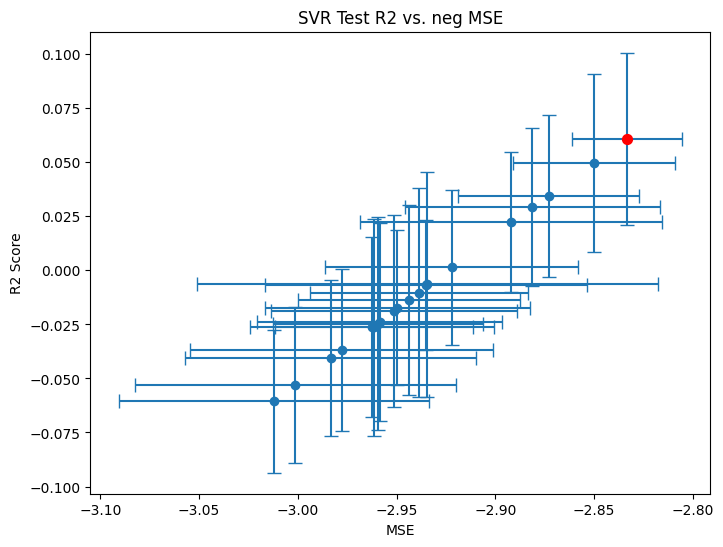

In [367]:
mean_test_scores = rand_poly.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_poly.cv_results_['mean_test_r2']
std_test_score = rand_poly.cv_results_['std_test_mse']
std_test_r2_scores = rand_poly.cv_results_['std_test_r2']
best_i = rand_poly.best_index_

plt.figure(figsize=(8, 6))
plt.errorbar(mean_test_scores, mean_test_r2_scores, xerr = std_test_score ,yerr=std_test_r2_scores, fmt='o', capsize=5)
plt.scatter(mean_test_scores[best_i], mean_test_r2_scores[best_i], color='red', s=50, zorder=10)
plt.xlabel('MSE')
plt.ylabel('R2 Score')
plt.title('SVR Test R2 vs. neg MSE')
plt.show()

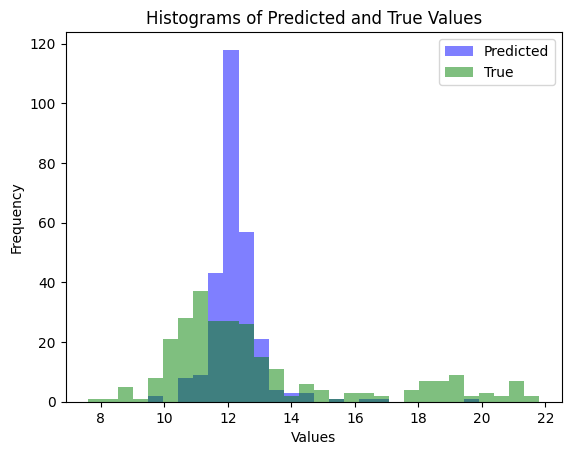

In [442]:
predicted_values = rand_poly.predict(X_test)
true_values = y_test
min_value = min(min(predicted_values), min(true_values[tested]))
max_value = max(max(predicted_values), max(true_values[tested]))

plt.hist(predicted_values, bins=30, range=(min_value, max_value), color='blue', alpha=0.5, label='Predicted')
plt.hist(true_values, bins=30, range=(min_value, max_value), color='green', alpha=0.5, label='True')


plt.title('Histograms of Predicted and True Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.legend(loc='upper right')

plt.show()

In [368]:
pSVRsigmoid = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(kernel='sigmoid'))
])


param_grid_sig = {'svr__C': c_values, 
              'svr__epsilon': epsilon_values}

rand_sig = RandomizedSearchCV(pSVRsigmoid, param_distributions=param_grid_sig,
                              scoring=scorers, refit='mse', verbose=1, cv=cv, n_iter=20,random_state=7)

rand_sig.fit(X_train, y_train.values.ravel())
exp_models["rand_sig"]=rand_sig
print("Best hyperparameters: ", rand_sig.best_params_)
print("Cross-validation score: ", rand_sig.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'svr__C': 0.10163416480906615, 'svr__epsilon': 0.21865347140571714}
Cross-validation score:  -2.8807122958779576


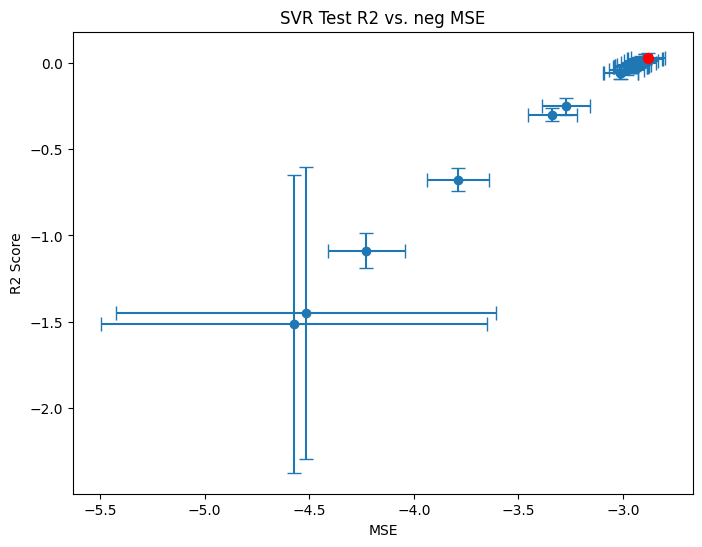

In [369]:
mean_test_scores = rand_sig.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_sig.cv_results_['mean_test_r2']
std_test_score = rand_sig.cv_results_['std_test_mse']
std_test_r2_scores = rand_sig.cv_results_['std_test_r2']
best_i = rand_sig.best_index_

plt.figure(figsize=(8, 6))
plt.errorbar(mean_test_scores, mean_test_r2_scores, xerr = std_test_score ,yerr=std_test_r2_scores, fmt='o', capsize=5)
plt.scatter(mean_test_scores[best_i], mean_test_r2_scores[best_i], color='red', s=50, zorder=10)
plt.xlabel('MSE')
plt.ylabel('R2 Score')
plt.title('SVR Test R2 vs. neg MSE')
plt.show()

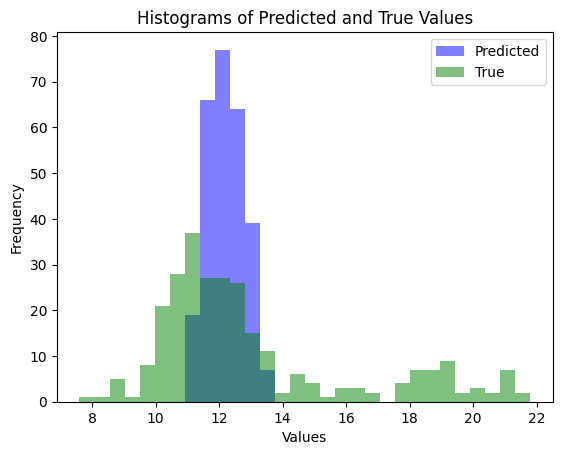

In [443]:
predicted_values = rand_sig.predict(X_test)
true_values = y_test
min_value = min(min(predicted_values), min(true_values[tested]))
max_value = max(max(predicted_values), max(true_values[tested]))

plt.hist(predicted_values, bins=30, range=(min_value, max_value), color='blue', alpha=0.5, label='Predicted')
plt.hist(true_values, bins=30, range=(min_value, max_value), color='green', alpha=0.5, label='True')


plt.title('Histograms of Predicted and True Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.legend(loc='upper right')

plt.show()

In [370]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np


pRT = Pipeline([
    ('preprocessor', preprocessor),
    ('rt', RandomForestRegressor())
])

param_dist_rt = {
    'rt__n_estimators': [10, 50, 100],
    'rt__max_depth': [2, 4, 6, None],
    'rt__min_samples_split': [2, 5, 10],
    'rt__min_samples_leaf': [1, 2, 4],
}


rand_rt = RandomizedSearchCV(estimator=pRT, param_distributions=param_dist_rt, 
                             n_iter=20, cv=cv, random_state=7, 
                             scoring=scorers, refit='mse', verbose=1)

rand_rt.fit(X_train, y_train.values.ravel())
exp_models["rand_rt"]=rand_rt
print("Best hyperparameters:", rand_rt.best_params_)
print("Best cross-validation score:", rand_rt.best_score_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'rt__n_estimators': 100, 'rt__min_samples_split': 5, 'rt__min_samples_leaf': 4, 'rt__max_depth': 6}
Best cross-validation score: -2.6764511542990475


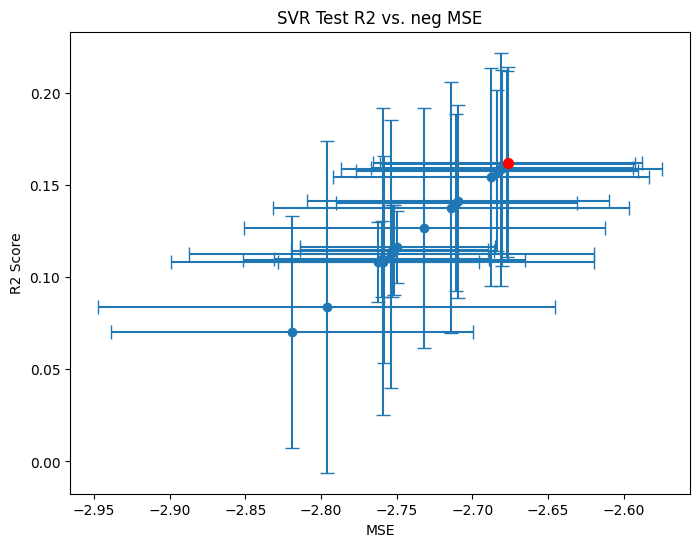

In [371]:
mean_test_scores = rand_rt.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_rt.cv_results_['mean_test_r2']
std_test_score = rand_rt.cv_results_['std_test_mse']
std_test_r2_scores = rand_rt.cv_results_['std_test_r2']
best_i = rand_rt.best_index_

plt.figure(figsize=(8, 6))
plt.errorbar(mean_test_scores, mean_test_r2_scores, xerr = std_test_score ,yerr=std_test_r2_scores, fmt='o', capsize=5)
plt.scatter(mean_test_scores[best_i], mean_test_r2_scores[best_i], color='red', s=50, zorder=10)
plt.xlabel('MSE')
plt.ylabel('R2 Score')
plt.title('SVR Test R2 vs. neg MSE')
plt.show()

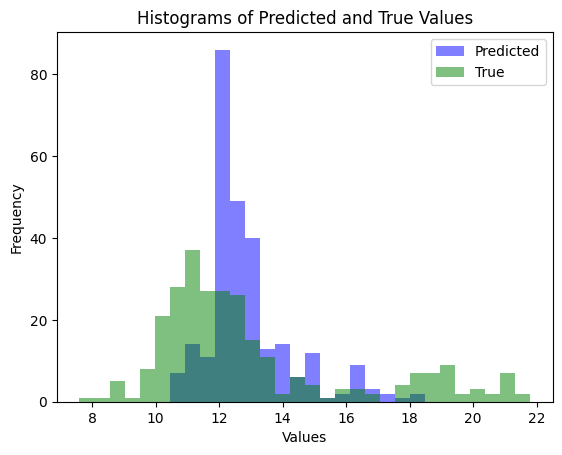

In [444]:
predicted_values = rand_rt.predict(X_test)
true_values = y_test
min_value = min(min(predicted_values), min(true_values[tested]))
max_value = max(max(predicted_values), max(true_values[tested]))

plt.hist(predicted_values, bins=30, range=(min_value, max_value), color='blue', alpha=0.5, label='Predicted')
plt.hist(true_values, bins=30, range=(min_value, max_value), color='green', alpha=0.5, label='True')


plt.title('Histograms of Predicted and True Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.legend(loc='upper right')

plt.show()


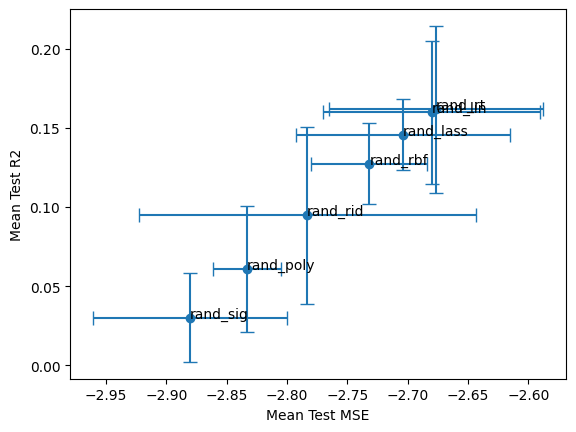

In [409]:
mse_scores = []
mse_err = []
r2_scores = []
r2_err = []
model_names = []

for key, model in exp_models.items():
    mse_scores.append(model.cv_results_['mean_test_mse'][model.best_index_])
    r2_scores.append(model.cv_results_['mean_test_r2'][model.best_index_])
    mse_err.append(model.cv_results_['std_test_mse'][model.best_index_])
    r2_err.append(model.cv_results_['std_test_r2'][model.best_index_])
    model_names.append(key)

fig, ax = plt.subplots()
plt.errorbar(mse_scores, r2_scores, xerr = mse_err ,yerr=r2_err, fmt='o', capsize=5)
for i, txt in enumerate(model_names):
    ax.annotate(txt, (mse_scores[i], r2_scores[i]))
ax.set_xlabel('Mean Test MSE')
ax.set_ylabel('Mean Test R2')
plt.show()

In [382]:
from scipy.stats import ttest_rel, wilcoxon

model_results = {}
            
def compare_models_mse(k1,k2):
    m1 = exp_models[k1]
    m2 = exp_models[k2]
    scores1 =  [m1.cv_results_['split{}_test_mse'.format(i)][m1.best_index_] for i in range(5)]
    scores2 =  [m1.cv_results_['split{}_test_mse'.format(i)][m2.best_index_] for i in range(5)]
    t, p = ttest_rel(scores1, scores2)
    if p<0.05:
        if t<0:
            print(f'model {k2} better than {k1} (ttest)')
        elif t>0:
            print(f'model {k1} better than {k2} (ttest)')
    _, p = wilcoxon(scores1, scores2)
    if p<0.05:
        _, p = wilcoxon(scores1, scores2, alternative= "greater")
        if p<0.05:
            print(f'model {k1} better than {k2} (wilcoxon)')
        else:
            _, p = wilcoxon(scores1, scores2, alternative= "less")
            if p<0.05:
                print(f'model {k2} better than {k1} (wilcoxon)')

def compare_models_r2(k1,k2):
    m1 = exp_models[k1]
    m2 = exp_models[k2]
    scores1 =  [m1.cv_results_['split{}_test_r2'.format(i)][m1.best_index_] for i in range(5)]
    scores2 =  [m1.cv_results_['split{}_test_r2'.format(i)][m2.best_index_] for i in range(5)]
    t, p = ttest_rel(scores1, scores2)
    if p<0.05:
        if t<0:
            print(f'model {k2} better than {k1} (ttest)')
        elif t>0:
            print(f'model {k1} better than {k2} (ttest)')
    _, p = wilcoxon(scores1, scores2)
    if p<0.05:
        _, p = wilcoxon(scores1, scores2, alternative= "greater")
        if p<0.05:
            print(f'model {k1} better than {k2} (wilcoxon)')
        else:
            _, p = wilcoxon(scores1, scores2, alternative= "less")
            if p<0.05:
                print(f'model {k2} better than {k1} (wilcoxon)')

In [383]:
tested_model = "rand_rt"
for key in exp_models.keys():
    if tested_model != key:
        compare_models_mse(tested_model, key)

print()
print()
for key in exp_models.keys():
    if tested_model != key:
        compare_models_r2(tested_model, key)



model rand_rt better than rand_lin (ttest)
model rand_rt better than rand_rbf (ttest)
model rand_rt better than rand_sig (ttest)


model rand_rt better than rand_lin (ttest)
model rand_rt better than rand_rbf (ttest)
model rand_rt better than rand_sig (ttest)
